In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

In [ ]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
#transfer learning begins
import pathlib

data_root = pathlib.Path('./dataset')

class_dirs = ['leaf', 'non_leaf']

data_paths = [data_root / class_name for class_name in class_dirs]

for path in data_paths:
    assert path.exists(), f"Could not find directory at {path}"

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [4]:
# result_batch = classifier.predict(train_ds) # results in the process halting in the middle

try:
    result_batch = classifier.predict(train_ds, batch_size=8, verbose=1)
except tf.errors.ResourceExhaustedError:
    print("Out of memory error - try reducing batch size")
except Exception as e:
    print(f"Error during prediction: {str(e)}")

Error during prediction: name 'classifier' is not defined


In [18]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['head cabbage', 'custard apple', 'lorikeet', ..., 'jaguar',
       'leafhopper', 'minibus'], dtype='<U30')

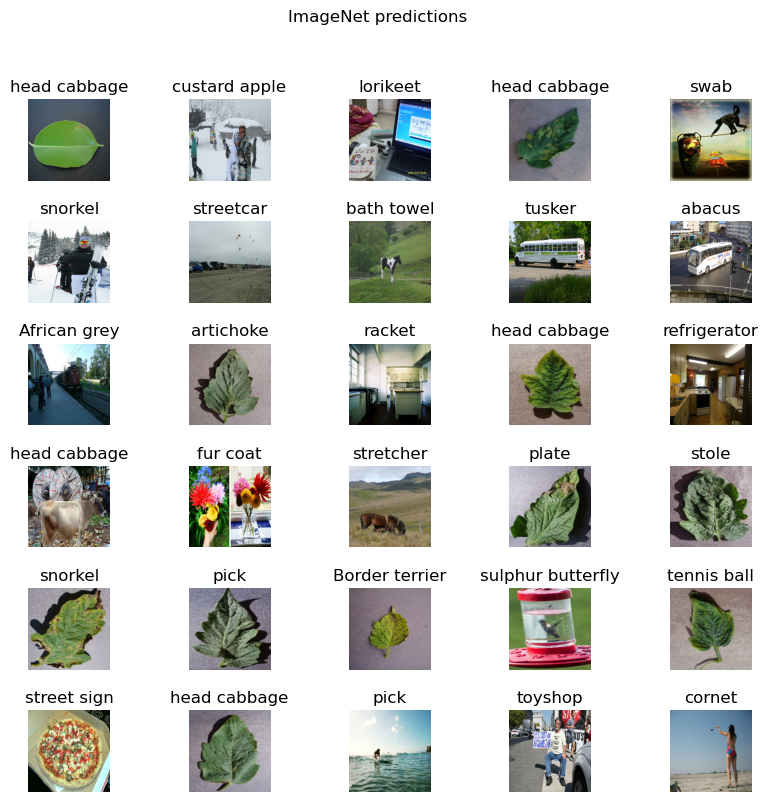

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
#headless model begins now

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 2])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [27]:
NUM_EPOCHS = 5

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
638/638 [==============================] - 168s 261ms/step - loss: 0.0110 - acc: 0.9976 - val_loss: 9.1312e-04 - val_acc: 1.0000
Epoch 2/10
638/638 [==============================] - 175s 274ms/step - loss: 7.4014e-04 - acc: 1.0000 - val_loss: 4.0208e-04 - val_acc: 1.0000
Epoch 3/10
638/638 [==============================] - 118s 185ms/step - loss: 3.8401e-04 - acc: 1.0000 - val_loss: 2.5603e-04 - val_acc: 1.0000
Epoch 4/10
165/638 [======>.......................] - ETA: 58s - loss: 3.3242e-04 - acc: 0.9998

KeyboardInterrupt: 

In [28]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 913ms/step
['leaf' 'non_leaf' 'non_leaf' 'leaf' 'non_leaf' 'non_leaf' 'non_leaf'
 'non_leaf' 'non_leaf' 'non_leaf' 'non_leaf' 'leaf' 'non_leaf' 'leaf'
 'non_leaf' 'non_leaf' 'non_leaf' 'non_leaf' 'leaf' 'leaf' 'leaf' 'leaf'
 'leaf' 'non_leaf' 'leaf' 'non_leaf' 'leaf' 'non_leaf' 'non_leaf'
 'non_leaf' 'non_leaf' 'leaf']


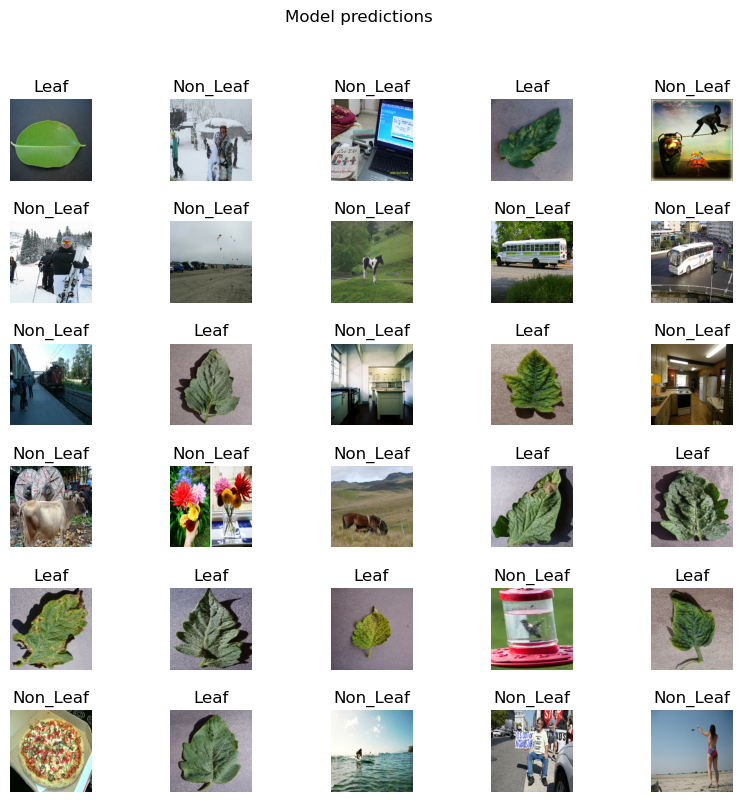

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [30]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1736848290\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1736848290\assets


'/tmp/saved_models/1736848290'

In [35]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 323ms/step


['leaf' 'non_leaf' 'non_leaf' 'leaf' 'non_leaf' 'non_leaf' 'non_leaf'
 'non_leaf' 'non_leaf' 'non_leaf' 'non_leaf' 'leaf' 'non_leaf' 'leaf'
 'non_leaf' 'non_leaf' 'non_leaf' 'non_leaf' 'leaf' 'leaf' 'leaf' 'leaf'
 'leaf' 'non_leaf' 'leaf' 'non_leaf' 'leaf' 'non_leaf' 'non_leaf'
 'non_leaf' 'non_leaf' 'leaf']


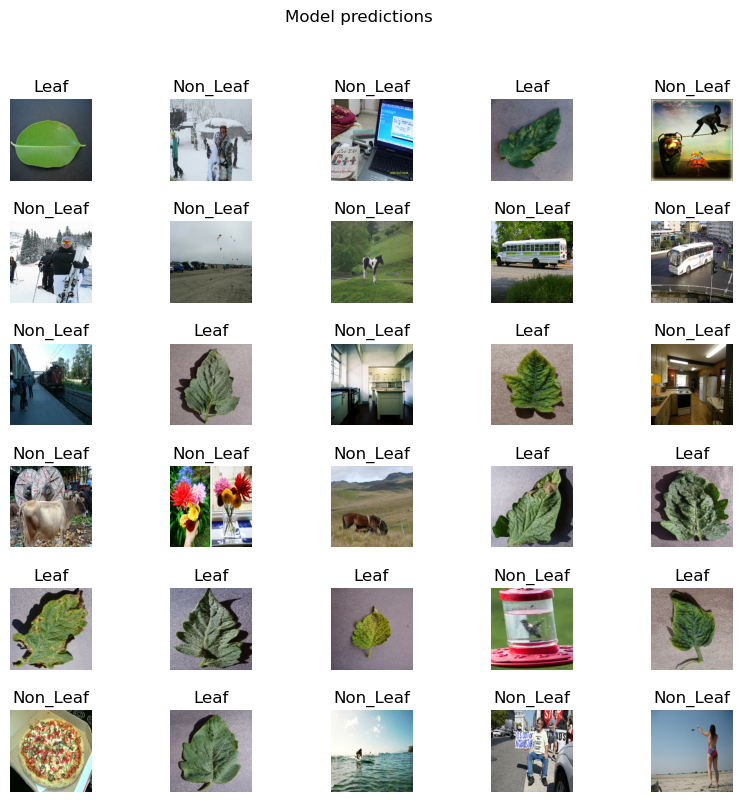

In [36]:
abs(reloaded_result_batch - result_batch).max()

reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [33]:
import time
import os

# Get the current time as a unique identifier
t = time.time()

# Get the current working directory
current_directory = os.getcwd()

# Define the export path using the current directory
export_path = os.path.join(current_directory, "saved_models", str(int(t)))

# Create the directory if it doesn't exist
os.makedirs(export_path, exist_ok=True)

# Save the model
model.save(export_path)

# Output the export path
export_path


INFO:tensorflow:Assets written to: E:\LEAF-NON_LEAF\leaf classifier\leaf_nonleaf\saved_models\1736848553\assets


INFO:tensorflow:Assets written to: E:\LEAF-NON_LEAF\leaf classifier\leaf_nonleaf\saved_models\1736848553\assets


'E:\\LEAF-NON_LEAF\\leaf classifier\\leaf_nonleaf\\saved_models\\1736848553'

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np

class_names = np.array(['leaf', 'non_leaf'])

In [3]:

def load_and_preprocess_image(image_path, target_size=(224, 224)):  # Adjust target_size to match your model's input size
    # Load the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=target_size
    )
    
    # Convert to array and add batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    # Normalize pixel values
    img_array = img_array / 255.0  # Scale pixels between 0 and 1
    
    return img_array

In [4]:
# Load the model
reloaded = tf.keras.models.load_model("saved_models/saved")

reloaded.save("E:\LEAF-NON_LEAF\leaf classifier\leaf_nonleaf\model.h5", save_format='h5')

In [6]:
# Preprocess the image
image_array = load_and_preprocess_image("image.jpg")

# Make prediction
predicted = reloaded.predict(image_array)
predicted_id = tf.math.argmax(predicted, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

ValueError: in user code:

    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)
